# 경향이 비슷한 과거 사례 그래프 추천

In [571]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StringType, ArrayType, DoubleType, MapType
from typing import Dict
from dtaidistance import dtw
import pandas as pd
from datetime import datetime, timedelta

In [572]:
# Spark 세션 초기화
spark = SparkSession.builder \
    .appName("RDS to Spark") \
    .master("local[*]") \
    .config("spark.executor.memory", "20g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.jars", "mysql-connector-java.jar") \
    .getOrCreate()

# graph score 구하기

In [573]:
JDBC_URL = "jdbc:mysql://hyundata2-rds.cz8k028q2kf9.ap-southeast-2.rds.amazonaws.com:3306/hyundata_db"
DB_USER = "hyundata2"
DB_PASSWORD = "hyundata2!"
DB_NAME = "post"

origin_df = spark.read \
    .format("jdbc") \
    .option("url", JDBC_URL) \
    .option("dbtable", DB_NAME) \
    .option("user", DB_USER) \
    .option("password", DB_PASSWORD) \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .load()

origin_df = origin_df.drop(F.col('title'), F.col('body'), F.col('comments'))
origin_df = origin_df.withColumn('issue_list', F.from_json(F.col("issue"), ArrayType(StringType())))
defect_df = origin_df.withColumn('indiv_issue', F.explode('issue_list')).drop(F.col("issue"), F.col("issue_list"))

# 로그 변환 및 정규화
defect_df = defect_df.withColumn("log_num_views", F.log1p("num_views")).withColumn("log_num_likes", F.log1p("num_likes"))
defect_group_df = defect_df.groupBy('community').agg(
    F.min('num_views').alias('min_num_views'),
    F.max('num_views').alias('max_num_views'),
    F.min('num_likes').alias('min_num_likes'),
    F.max('num_likes').alias('max_num_likes'),
    F.min('log_num_views').alias('min_log_num_views'),
    F.max('log_num_views').alias('max_log_num_views'),
    F.min('log_num_likes').alias('min_log_num_likes'),
    F.max('log_num_likes').alias('max_log_num_likes')
)
defect_df = defect_df.join(defect_group_df, on=['community'])

def normalize_column(df, col_name, group_col):
    min_col = f"min_{col_name}"
    max_col = f"max_{col_name}"
    normalized_col = f"normalized_{col_name}"
    return df.withColumn(
        normalized_col,
        (F.col(col_name) - F.col(min_col)) / (F.col(max_col) - F.col(min_col))
    )

defect_df = normalize_column(defect_df, "num_views", "community")
defect_df = normalize_column(defect_df, "num_likes", "community")
defect_df = normalize_column(defect_df, "log_num_views", "community")
defect_df = normalize_column(defect_df, "log_num_likes", "community")

defect_df = defect_df.drop(
    F.col("min_num_views"), F.col('max_num_views'), F.col('min_num_likes'), F.col('max_num_likes'),
    F.col('min_log_num_views'), F.col('max_log_num_views'), F.col('min_log_num_likes'), F.col('max_log_num_likes')
)

# 그룹화 및 평균/합계 계산
defect_grouped_df = defect_df.groupBy("indiv_issue", "car_name", 'upload_date').agg(
    F.avg("normalized_log_num_views").alias("normalized_avg_log_num_views"),
    F.sum("normalized_log_num_likes").alias("normalized_sum_log_num_likes")
)

rdd = defect_grouped_df.orderBy("indiv_issue", "car_name", "upload_date").rdd

def apply_exponential_smoothing(partition, alpha, beta):
    prev_exp_smoothed_view = None
    prev_exp_smoothed_like = None
    result = []
    for row in partition:
        if prev_exp_smoothed_view is None: exp_smoothed_view = row["normalized_avg_log_num_views"]
        else:                              exp_smoothed_view = alpha * row["normalized_avg_log_num_views"] + (1 - alpha) * prev_exp_smoothed_view
        if prev_exp_smoothed_like is None: exp_smoothed_like = row["normalized_sum_log_num_likes"]
        else:                              exp_smoothed_like = beta * row["normalized_sum_log_num_likes"] + (1 - beta) * prev_exp_smoothed_like
        result.append(
            Row(
                indiv_issue=row["indiv_issue"],
                car_name=row["car_name"],
                upload_date=row["upload_date"],
                normalized_avg_log_num_views=row["normalized_avg_log_num_views"],
                normalized_sum_log_num_likes=row["normalized_sum_log_num_likes"],
                exp_smoothed_normalized_avg_log_num_views=exp_smoothed_view,
                exp_smoothed_normalized_sum_log_num_likes=exp_smoothed_like
            )
        )
        prev_exp_smoothed_view = exp_smoothed_view
        prev_exp_smoothed_like = exp_smoothed_like
    return iter(result)

# 지수 평활법 적용
alpha = 0.05
beta = 0.02
result_rdd = rdd.mapPartitions(lambda partition: apply_exponential_smoothing(partition, alpha, beta))

result_df = result_rdd.toDF()
result_df = result_df.withColumn(
    "norm_graph_score",
    F.col('exp_smoothed_normalized_avg_log_num_views') * F.col('exp_smoothed_normalized_sum_log_num_likes')
)
result_df.show()

+-----------+--------+-----------+----------------------------+----------------------------+-----------------------------------------+-----------------------------------------+--------------------+
|indiv_issue|car_name|upload_date|normalized_avg_log_num_views|normalized_sum_log_num_likes|exp_smoothed_normalized_avg_log_num_views|exp_smoothed_normalized_sum_log_num_likes|    norm_graph_score|
+-----------+--------+-----------+----------------------------+----------------------------+-----------------------------------------+-----------------------------------------+--------------------+
|       ICCU|  그랜저| 2019-01-10|          0.5090889089692516|                         0.0|                       0.5090889089692516|                                      0.0|                 0.0|
|       ICCU|  그랜저| 2019-01-11|         0.48481431228795197|                         0.0|                       0.5078751791351866|                                      0.0|                 0.0|
|       ICCU|  그

# DTW

In [574]:
import json

# DTW 거리를 계산하는 UDF 정의
def calculate_dtw_distance(monitor_list_str, issue_list_str):
    # JSON 문자열을 파싱하여 숫자형 리스트로 변환
    try:
        monitor_list = [json.loads(item)['norm_graph_score'] for item in monitor_list_str]
        issue_list = [json.loads(item)['norm_graph_score'] for item in issue_list_str]
    except Exception as e:
        print(e, monitor_list_str, issue_list_str)

    if isinstance(monitor_list, str):
        monitor_list = json.loads(monitor_list)
    if isinstance(issue_list, str):
        issue_list = json.loads(issue_list)
    
    # DTW 거리 계산
    return float(dtw.distance(monitor_list, issue_list))

dtw_distance_udf = F.udf(calculate_dtw_distance, DoubleType())

In [575]:
# 요구 조건에 맞는 데이터 추출
def extract_graph_score_list(df: DataFrame, car_name: str, issue: str, start_date, end_date) -> DataFrame:
    query = df.filter(
        (F.col("car_name") == car_name) & 
        (F.col("indiv_issue") == issue) & 
        (F.col("upload_date") >= start_date) &
        (F.col("upload_date") <= end_date)
    )
    
    graph_score_list = (
        query.select(F.to_json(F.struct(F.col("upload_date"), F.col("norm_graph_score"))).alias("graph_score_json"))
        .groupBy()
        .agg(F.collect_list("graph_score_json").alias("graph_score_list"))
    )
    
    return graph_score_list

In [576]:
# 추천 요소를 생성하는 함수
def create_recommend_element(df: DataFrame, recommendation: Dict[str, str]) -> Dict:
    recommend_car_name = recommendation["recommend_car_name"]
    recommend_issue = recommendation["recommend_issue"]
    recommend_start_date = recommendation["recommend_start_date"]
    
    # 날짜 필터링
    recommend_start_date_col = F.lit(recommend_start_date).cast("date")
    recommend_start_date_plus_3months = F.date_add(recommend_start_date_col, 90)
    recommend_start_date_minus_3months = F.date_add(recommend_start_date_col, -90)
    
    recommend_graph_score_list_df = extract_graph_score_list(
        df,
        recommend_car_name,
        recommend_issue,
        recommend_start_date_minus_3months,
        recommend_start_date_plus_3months
    )

    # JSON 문자열을 딕셔너리로 변환
    graph_score_list = recommend_graph_score_list_df.collect()[0]["graph_score_list"]
    parsed_graph_score_list = [json.loads(score) for score in graph_score_list]
    
    return {
        "dtw_distance": recommendation['dtw_distance'],
        "recommend_car_name": recommend_car_name,
        "recommend_issue": recommend_issue,
        "recommend_start_date": recommend_start_date,
        "recommend_graph_score_list": parsed_graph_score_list
    }

In [577]:
# monitor_car_name과 monitor_issue를 지정
monitor_car_name = "그랜저"
monitor_issue = "엔진"

today = F.current_date()
three_months_ago = F.date_add(today, -90)

In [578]:
# 모니터링 대상의 graph_score_list 추출
monitor_graph_score_list = extract_graph_score_list(
    result_df,
    monitor_car_name,
    monitor_issue,
    three_months_ago,
    today
).collect()[0]["graph_score_list"]

In [579]:
with open('./defect_data.json', 'r', encoding='utf-8') as f:
    total_issues = json.load(f)

In [580]:
df_issues = []
for issue in total_issues:
    car_name = issue["car_name"]
    issue_name = issue["defect_type"]
    trigger_date = pd.to_datetime(issue["news_dates"][0])

    issue_df = extract_graph_score_list(
        df=result_df,
        car_name=car_name,
        issue=issue_name,
        start_date=trigger_date - pd.DateOffset(months=3),
        end_date=trigger_date + pd.DateOffset(months=3)
    ).withColumn("car_name", F.lit(car_name)).withColumn("issue_name", F.lit(issue_name))
    
    df_issues.append(issue_df)

# 모든 issue DataFrame을 합치기
combined_issues_df = df_issues[0]
for df_issue in df_issues[1:]:
    combined_issues_df = combined_issues_df.union(df_issue)

In [581]:
# DTW 거리 계산
final_df = combined_issues_df.withColumn(
    "distance",
    dtw_distance_udf(F.lit(monitor_graph_score_list), combined_issues_df["graph_score_list"])
)

# DTW 거리가 가장 작은 이슈들로 추천 리스트 작성
recommendations = final_df.orderBy("distance").limit(5).collect()

In [582]:
final_recommendations = []
for row in recommendations:
    final_recommendations.append(create_recommend_element(
        result_df,
        {
            "recommend_car_name": row["car_name"], 
            "recommend_issue": row["issue_name"], 
            "dtw_distance": row["distance"],
            "recommend_start_date": json.loads(row["graph_score_list"][0])["upload_date"]
        }
    ))

In [583]:
monitor_graph_score_list = [json.loads(score) for score in monitor_graph_score_list]

def move_base_date(reco, today):
    dates = reco['recommend_graph_score_list']
    start_date = datetime.strptime(reco['recommend_start_date'], '%Y-%m-%d')
    today_datetime = datetime.combine(today, datetime.min.time())
    delta = (today_datetime - start_date).days
    
    # 날짜 이동 적용
    reco['recommend_graph_score_list'] = [
        {
            'upload_date': (datetime.strptime(date['upload_date'], '%Y-%m-%d') + timedelta(days=delta)).strftime('%Y-%m-%d'),
            'norm_graph_score': date['norm_graph_score']
        } 
        for date in dates
    ]
    return reco

# Spark Column 'today' 값을 로컬로 수집
today_value = result_df.select(F.current_date().alias('today')).first()['today']

final_recommendations_date_moved = [move_base_date(reco, today_value) for reco in final_recommendations]
final_recommendations_date_moved

[{'dtw_distance': 0.08890252334641652,
  'recommend_car_name': '그랜저',
  'recommend_issue': '단차',
  'recommend_start_date': '2022-10-23',
  'recommend_graph_score_list': [{'upload_date': '2024-05-22',
    'norm_graph_score': 0.008556640413868884},
   {'upload_date': '2024-05-26', 'norm_graph_score': 0.008247117558955831},
   {'upload_date': '2024-05-28', 'norm_graph_score': 0.008851675509546799},
   {'upload_date': '2024-05-31', 'norm_graph_score': 0.00860953174494964},
   {'upload_date': '2024-06-22', 'norm_graph_score': 0.008446615417621962},
   {'upload_date': '2024-06-23', 'norm_graph_score': 0.008226296168412053},
   {'upload_date': '2024-06-27', 'norm_graph_score': 0.008702445146670113},
   {'upload_date': '2024-06-29', 'norm_graph_score': 0.009644036643589291},
   {'upload_date': '2024-06-30', 'norm_graph_score': 0.010161080477933586},
   {'upload_date': '2024-07-10', 'norm_graph_score': 0.009911602615524758},
   {'upload_date': '2024-07-14', 'norm_graph_score': 0.009428413658941

In [584]:
final_monitoring = {
    "monitor_car_name": monitor_car_name,
    "monitor_issue": monitor_issue,
    "monitor_graph_score_list": monitor_graph_score_list,
    "recommendation_json": final_recommendations
}

final_monitoring

{'monitor_car_name': '그랜저',
 'monitor_issue': '엔진',
 'monitor_graph_score_list': [{'upload_date': '2024-05-22',
   'norm_graph_score': 0.03592099205072779},
  {'upload_date': '2024-05-23', 'norm_graph_score': 0.03517405506741112},
  {'upload_date': '2024-05-24', 'norm_graph_score': 0.034494095209199785},
  {'upload_date': '2024-05-25', 'norm_graph_score': 0.03344727563569031},
  {'upload_date': '2024-05-26', 'norm_graph_score': 0.03255609746012483},
  {'upload_date': '2024-05-27', 'norm_graph_score': 0.03443821231059765},
  {'upload_date': '2024-05-28', 'norm_graph_score': 0.03350215567595893},
  {'upload_date': '2024-05-29', 'norm_graph_score': 0.03260566761106093},
  {'upload_date': '2024-05-30', 'norm_graph_score': 0.03210540076813631},
  {'upload_date': '2024-05-31', 'norm_graph_score': 0.03244190771450826},
  {'upload_date': '2024-06-01', 'norm_graph_score': 0.032516464804676196},
  {'upload_date': '2024-06-03', 'norm_graph_score': 0.031668921499231714},
  {'upload_date': '2024-06

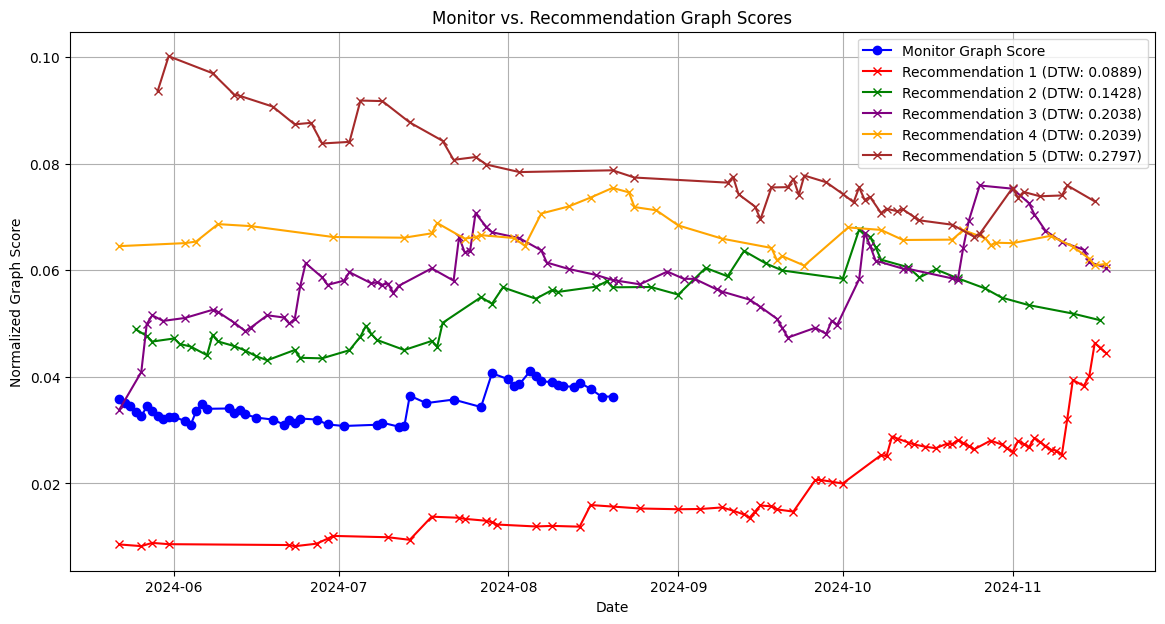

In [585]:
import matplotlib.pyplot as plt
from datetime import datetime

# monitor_graph_score_list는 이미 json.loads()로 파싱되어 있다고 가정합니다.
monitor_dates = [datetime.strptime(item['upload_date'], '%Y-%m-%d') for item in monitor_graph_score_list]
monitor_scores = [item['norm_graph_score'] for item in monitor_graph_score_list]

# Plot 설정
plt.figure(figsize=(14, 7))

# Monitor graph plot
plt.plot(monitor_dates, monitor_scores, label="Monitor Graph Score", color='blue', marker='o')

# Recommend graph plot들
colors = ['red', 'green', 'purple', 'orange', 'brown']  # 최대 5개의 추천 리스트 색상
for idx, recommendation in enumerate(final_recommendations):
    recommend_graph_score_list = recommendation['recommend_graph_score_list']
    recommend_dates = [datetime.strptime(item['upload_date'], '%Y-%m-%d') for item in recommend_graph_score_list]
    recommend_scores = [item['norm_graph_score'] for item in recommend_graph_score_list]
    plt.plot(recommend_dates, recommend_scores, label=f"Recommendation {idx+1} (DTW: {recommendation['dtw_distance']:.4f})", color=colors[idx], marker='x')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Normalized Graph Score")
plt.title("Monitor vs. Recommendation Graph Scores")
plt.legend()

# Show plot
plt.grid(True)
plt.show()